### **Predict Bee species from image using SVM**

In [213]:
# used to change filepaths
import os

import matplotlib as mpl
import matplotlib.pyplot as plt
from IPython.display import display
%matplotlib inline

import pandas as pd
import numpy as np

# import Image from PIL
from PIL import Image

from skimage.feature import hog
from skimage.color import rgb2gray

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# import train_test_split from sklearn's model selection module
from sklearn.model_selection import train_test_split

# import SVC from sklearn's svm module
from sklearn.svm import SVC

# import accuracy_score from sklearn's metrics module
from sklearn.metrics import roc_curve, auc, accuracy_score

In [214]:
# load the labels using pandas
labels = pd.read_csv("datasets/labels.csv", index_col=0)

# show the first five rows of the dataframe using head
display(labels.head())

,genus
id,
520,1.0
3800,1.0
3289,1.0
2695,1.0
4922,1.0


let's make a function to retrieve the image

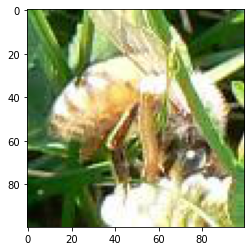

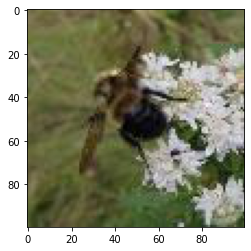

In [215]:
def get_image(row_id, root="datasets/"):
    """
    Converts an image number into the file path where the image is located, 
    opens the image, and returns the image as a numpy array.
    """
    filename = "{}.jpg".format(row_id)
    file_path = os.path.join(root, filename)
    img = Image.open(file_path)
    return np.array(img)

# subset the dataframe to just Apis (genus is 0.0) get the value of the first item in the index
apis_row = labels[labels.genus == 0.0].index[0]

# show the corresponding image of an Apis
plt.imshow(get_image(apis_row))
plt.show()

# subset the dataframe to just Bombus (genus is 1.0) get the value of the first item in the index
bombus_row = labels[labels.genus == 1.0].index[0]

# show the corresponding image of a Bombus
plt.imshow(get_image(bombus_row))
plt.show()

convert the picture into gray image

Color bombus image has shape:  (100, 100, 3)
Grayscale bombus image has shape:  (100, 100)


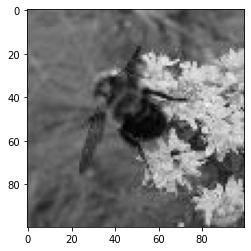

In [216]:
# load a bombus image using our get_image function and bombus_row from the previous cell
bombus = get_image(bombus_row)

# print the shape of the bombus image
print('Color bombus image has shape: ', bombus.shape)

# convert the bombus image to grayscale
gray_bombus = rgb2gray(bombus)

# show the grayscale image
plt.imshow(gray_bombus, cmap=mpl.cm.gray)

# confirm grayscale bombus image only has one channel
print('Grayscale bombus image has shape: ', gray_bombus.shape)

It's hard for us to identify the bees. Let's hope that our algorithm will produce decent performance.

The algorithm can't identify feature from the pixel values. Let's make it more valuable by using **Histogram of Oriented Gradients** or **HOG**. An object's shape within an image can be inferred by its edges, and a way to identify edges is by looking at the direction of intensity gradients (i.e. changes in luminescence).


<p>An image is divided in a grid fashion into cells, and for the pixels within each cell, a histogram of gradient directions is compiled. To improve invariance to highlights and shadows in an image, cells are block normalized, meaning an intensity value is calculated for a larger region of an image called a block and used to contrast normalize all cell-level histograms within each block. The HOG feature vector for the image is the concatenation of these cell-level histograms.</p>

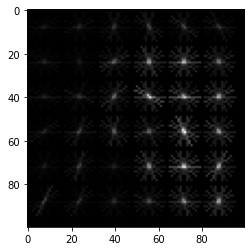

In [217]:
# run HOG using our grayscale bombus image
hog_features, hog_image = hog(gray_bombus,
                              visualize=True,
                              block_norm='L2-Hys',
                              pixels_per_cell=(16, 16))

# show our hog_image with a gray colormap
plt.imshow(hog_image, cmap=mpl.cm.gray)

<p>The algorithms require data to be in a format where rows correspond to images and columns correspond to features. This means that all the information for a given image needs to be contained in a single row.</p>
<p>We want to provide our model with the raw pixel values from our images as well as the HOG features we just calculated. To do this, we will write a function called <code>create_features</code> that combines these two sets of features by flattening the three-dimensional array into a one-dimensional (flat) array.</p>

In [218]:
def create_features(img):
    # flatten three channel color image
    color_features = img.flatten()
    # convert image to grayscale
    gray_image = rgb2gray(img)
    # get HOG features from grayscale image
    hog_features = hog(gray_image, block_norm='L2-Hys', pixels_per_cell=(16, 16))
    # combine color and hog features into a single array
    flat_features = np.hstack([color_features, hog_features])
    return flat_features

bombus_features = create_features(bombus)

# print shape of bombus_features
bombus_features.shape

(31296,)

<p>Above we generated a flattened features array for the bombus image. Now it's time to loop over all of our images. We will create features for each image and then stack the flattened features arrays into a big matrix we can pass into our model.</p>

In [219]:
def create_feature_matrix(label_dataframe):
    features_list = []
    
    for img_id in label_dataframe.index:
        # load image
        img = get_image(img_id, root="datasets/")
        # get features for image
        image_features = create_features(img)
        features_list.append(image_features)
        
    # convert list of arrays into a matrix
    feature_matrix = np.array(features_list)
    return feature_matrix

# run create_feature_matrix on our dataframe of images
feature_matrix = create_feature_matrix(labels)

now let's split the data test into 85-25% proportion

In [220]:
# split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(feature_matrix,
                                                    labels['genus'].values,
                                                    test_size=0.25,
                                                    random_state=1234123)

# look at the distribution of labels in the train set
pd.Series(y_train).value_counts()

1.0    188
0.0    187
dtype: int64

From cell 13, we can see that we have 31,296 features column - which is too much. So let's reduce the feature dimentionality (look at the example below). Let's try to do 700 features.
<p><img src="https://assets.datacamp.com/production/project_412/img/pca_cropped.png" alt="PCA"></p>

In [221]:
# get shape of our training features
print('Feature matrix shape is: ', X_train.shape)

# define standard scaler
ss = StandardScaler()

# fit the scaler and transform the training features
train_stand = ss.fit_transform(X_train)

pca = PCA(n_components=375)

# use fit_transform to run PCA on our standardized training matrix
X_train = pca.fit_transform(train_stand)

# look at new shape
print('PCA matrix shape is: ', X_train.shape)

Feature matrix shape is:  (375, 31296)
PCA matrix shape is:  (375, 375)


<p>Now we have scaled and performed PCA on our training features, we need to must do the same with the test set to ensure the same scale is applied to both sets, and the same volume of features used. </p>

In [222]:
# get shape of our test data
print('Feature matrix shape is: ', X_test.shape)

# use transform our test features
test_stand = ss.transform(X_test)

# use transform on our standardized test features
X_test = pca.transform(test_stand)

# look at new shape
print('PCA matrix shape is: ', X_test.shape)

Feature matrix shape is:  (125, 31296)
PCA matrix shape is:  (125, 375)


Now let's train the model. We will use SVM rather than Logistic Regression because it works well with unstructured data like text and images.

In [223]:
# define support vector classifier
svm = SVC(kernel='linear',probability=True,random_state=42)

# fit model
svm.fit(X_train,y_train)

SVC(kernel='linear', probability=True, random_state=42)

now let's check the model performance

In [224]:
# generate predictions
y_pred = svm.predict(X_test)

# calculate accuracy
accuracy = accuracy_score(y_test,y_pred)
print('Model accuracy is: ', accuracy)

Model accuracy is:  0.736


now let's use `.predict_proba` to get the probability for each class, and calculate AUC ROC score. 1 = best , 0.5 = worst

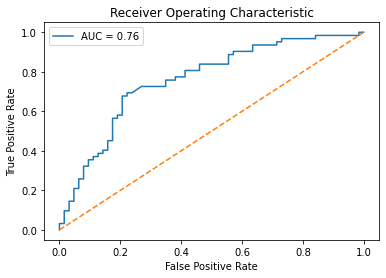

In [225]:
# predict probabilities for X_test using predict_proba
probabilities = svm.predict_proba(X_test)

# select the probabilities for label 1.0
y_proba = probabilities[:, 1]

# calculate false positive rate and true positive rate at different thresholds
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_proba, pos_label=1)

# calculate AUC
roc_auc = auc(false_positive_rate, true_positive_rate)

plt.title('Receiver Operating Characteristic')
# plot the false positive rate on the x axis and the true positive rate on the y axis
roc_plot = plt.plot(false_positive_rate,
                    true_positive_rate,
                    label='AUC = {:0.2f}'.format(roc_auc))

plt.legend(loc=0)
plt.plot([0,1], [0,1], ls='--')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate');

0.76 is not bad. I've tried tuning using GridSearchCV, but the performance increased doesn't really worth it.